# Count Vertices as a function of field

Below we classify the vertices obtained in [VertexStructure](VertexStructure.ipynb). In the end we obtain a dataset of the fraction of vertices, as a function of the magnetic field. 

In [1]:
import os
import sys
import glob
sys.path.insert(0, './')

import icenumerics as ice
from icenumerics.geometry import transformations as tr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook
import support as sp

idx = pd.IndexSlice
ureg = ice.ureg

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
directory = "C:/Users/aortiza/Desktop/ShearedSquare/Theta45"

All the vertices are stored in the same file, which makes reading it very easy. 

In [4]:
vrt = pd.read_csv(os.path.join(directory,"vertices_new.dat"), sep = "\t", index_col=[0,1,2])
vrt.head()

Coordination  Charge  \
filename                              frame id                         
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15             4       2   
                                            17             4       2   
                                            18             4       0   
                                            19             4      -2   
                                            21             4       0   

                                                 DipoleX   DipoleY  \
filename                              frame id                       
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15  1.394330 -1.433821   
                                            17 -1.394330  1.433821   
                                            18  1.422255  0.565984   
                                            19  0.027924  1.999805   
                                            21  1.422255  0.565984   

                                                 LocationX   LocationY  field  
filename                              frame id                                 
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15  291.459582   92.536974    0.0  
                                            17  461.130516  392.734273    0.0  
                                            18  235.991654   70.463604    0.0  
                                            19  405.662588  370.660903    0.0  
                                            21  572.066372  436.881012    0.0

The charged vertices are easy to classify. 

In [5]:
vrt["type"] = np.NaN
vrt.loc[vrt.Charge==-4, "type"] = "Type 1"
vrt.loc[vrt.Charge==-2, "type"] = "Type 2"
vrt.loc[vrt.Charge==+2, "type"] = "Type 5"
vrt.loc[vrt.Charge==+4, "type"] = "Type 6"

zeroq = vrt.Charge==0

dipole_magnitude = np.sqrt(vrt[zeroq].DipoleX**2+vrt[zeroq].DipoleY**2)

However, the dipole magnitude is very markedly different for each type, as shown in this histogram. This allows us to establish thresholds to separate the vertex type of the $q=0$ vertices.

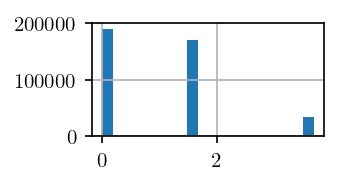

In [6]:
fig = plt.subplots(figsize=(2,1))
dipole_magnitude.hist(bins=20)

In [7]:
vrt.loc[zeroq & (dipole_magnitude<0.1), "type"] = "Type 3"
vrt.loc[zeroq & (dipole_magnitude>1.5) & (dipole_magnitude<1.7) , "type"] = "Type 4a"
vrt.loc[zeroq & (dipole_magnitude>3.5) , "type"] = "Type 4b"

In [8]:
vrt.head()

Coordination  Charge  \
filename                              frame id                         
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15             4       2   
                                            17             4       2   
                                            18             4       0   
                                            19             4      -2   
                                            21             4       0   

                                                 DipoleX   DipoleY  \
filename                              frame id                       
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15  1.394330 -1.433821   
                                            17 -1.394330  1.433821   
                                            18  1.422255  0.565984   
                                            19  0.027924  1.999805   
                                            21  1.422255  0.565984   

                                                 LocationX   LocationY  field  \
filename                              frame id                                  
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15  291.459582   92.536974    0.0   
                                            17  461.130516  392.734273    0.0   
                                            18  235.991654   70.463604    0.0   
                                            19  405.662588  370.660903    0.0   
                                            21  572.066372  436.881012    0.0   

                                                   type  
filename                              frame id           
E5_M8_teta45_10um_2019_06_04_15_32_20 0     15   Type 5  
                                            17   Type 5  
                                            18  Type 4a  
                                            19   Type 2  
                                            21  Type 4a

Now that all vertices are classified, we save the dataset.

In [9]:
vrt.to_csv(os.path.join(directory,"vertices_class.dat"), sep = "\t")

The usual counting ('groupby().count()') doesn't work because groupby doesn't return the values that don't appear in the group. That is, if there is zero Type 6 vertices, it will not return an index with $N_{Type 6}=0$. Then when we do the mean, they are not added, and the lowest value is one. For this, we created a new count_types function

In [10]:
def count_types(data):
    
    data["mean"] = 0
    cats = ["Type 1", "Type 2", "Type 3", "Type 4a", "Type 4b", "Type 5", "Type 6"]
    zeros = pd.DataFrame(np.zeros(len(cats)), columns=["mean"], index = cats)
    zeros.index.name="type"
    counts = zeros+data.groupby("type").count()
    counts[counts.isna()]=0
    return counts

vrt["mean"]=0

count = vrt.loc[:,["type","field"]].groupby(["filename","field"]).apply(count_types)
count = (count/vrt.groupby(["filename","field"]).count()).filter(["mean"])
count.head()

mean
filename                              field type         
E5_M8_teta45_10um_2019_06_04_15_32_20 0.0   Type 1   0.12
                                            Type 2   0.22
                                            Type 3   0.16
                                            Type 4a  0.06
                                            Type 4b  0.18

In [11]:
color = {"Type 1":"brown",
         "Type 2":"olive",
         "Type 3":"blue",
         "Type 4a":"red",
         "Type 4b":"orange",
         "Type 5":"cyan",
         "Type 6":"magenta"}

Below are plotted all the timeseries. They all have different `field` vector, which means they can't directly be averaged. 

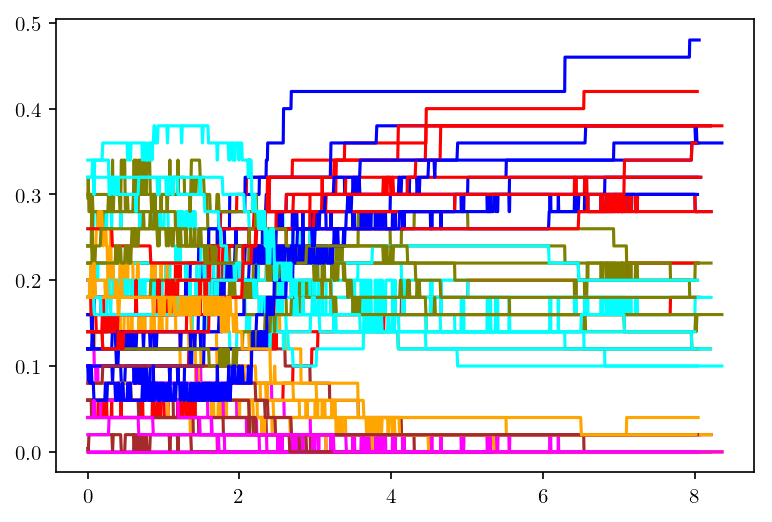

In [12]:
for ch,v in count.groupby(["filename","type"]):
    plt.plot(v.index.get_level_values("field"), v["mean"], color=color[ch[1]])

We make a function to return an interpolation at evenly spaced points, given by the `field` vector.

In [13]:
def evenly_spaced(series,space):
    series_w_space = pd.concat([
        series.droplevel([0,2]),series.droplevel([0,2]).reindex(space)]
    ).groupby(series.droplevel([0,2]).index.name).first().sort_index()
    
    series_w_space = series_w_space.interpolate(method="index")
    return series_w_space.loc[space]

In [14]:
field = np.linspace(0,8,101)

vert_prop_evenspace = count.groupby(["filename","type"]).apply(evenly_spaced,field)

The evenly spaced points are then averaged, and the error can be calculated from their standard deviation. 

In [15]:
v_counts = vert_prop_evenspace.groupby(["field","type"]).mean()
v_counts["err"] = vert_prop_evenspace.groupby(
    ["field","type"]).std()/np.sqrt(vert_prop_evenspace.groupby(["field","type"]).count().values)

Text(0, 0.5, 'Fraction of vertices')

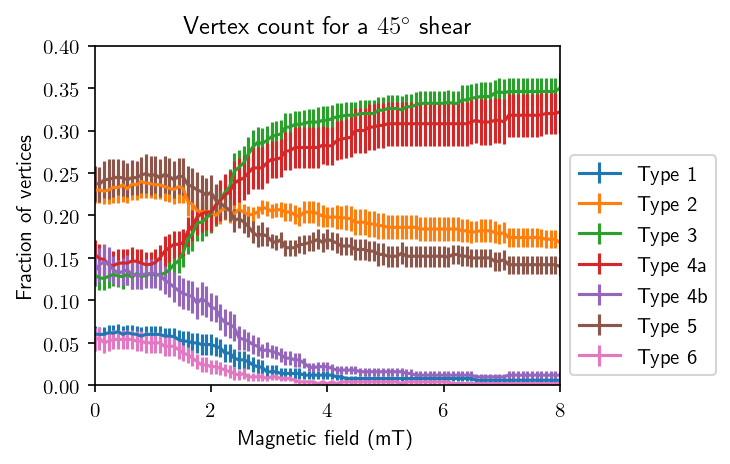

In [16]:
fig = plt.subplots(figsize=(4,3))

for typ, vtype in v_counts.groupby("type"):
    plt.errorbar(vtype.index.get_level_values("field"), vtype["mean"], yerr = vtype["err"], label = typ)
    
plt.ylim(0,0.4)
plt.xlim(0,8)    
plt.title(r"Vertex count for a $45^{\circ}$ shear")
plt.legend(loc = "lower left",bbox_to_anchor = (1,0))
plt.xlabel("Magnetic field (mT)")
plt.ylabel("Fraction of vertices")

In [17]:
v_counts.to_csv(os.path.join(directory,"vertex_counts.dat"), sep = "\t")